In [1]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import string

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
#data_folder = "./samples/"
data_folder = "/kaggle/input/imagecaptbase/samples/"
image_filename = lambda x: x.split("\\")[-1][:-4]
all_files = glob.glob(pathname = data_folder + "*.png")
print("Number of files: ", len(all_files))

Number of files:  1040


In [3]:
class ImageDataset(Dataset):
    def __init__(self, data_folder_path: str):
        super(Dataset, self).__init__()
        self.files = glob.glob(data_folder_path + "*.png")
        self.targets = list(map(image_filename, self.files))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx: int):
        image = io.imread(self.files[idx])
        target = self.targets[idx]
        # for kaggle:
        target = target.split("/")[-1]
        
        return image, target

MyDataset = ImageDataset(data_folder)
len(MyDataset)

1040

In [4]:
train_ratio = 0.7
train_size = int(train_ratio * len(MyDataset))
valid_size = len(MyDataset) - train_size
indexes = torch.randperm(len(MyDataset))

train_indexes = indexes[:train_size]
valid_indexes = indexes[train_size:]
assert not set(train_indexes.tolist()).intersection(set(valid_indexes.tolist()))

train_dataset = Subset(MyDataset, train_indexes)
valid_dataset = Subset(MyDataset, valid_indexes)
print(f"train files: {len(train_dataset)},   test files: {len(valid_dataset)}")

train files: 728,   test files: 312


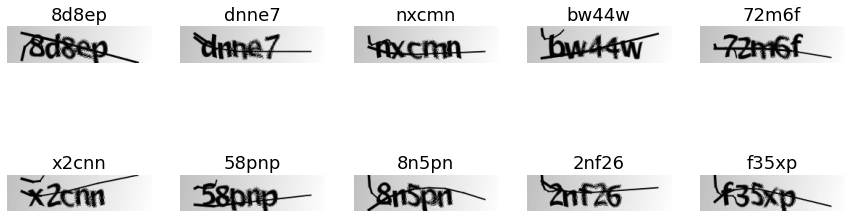

In [5]:
fig = plt.figure(figsize = (15, 5))
for i in range(10):
    sample = train_dataset[i]
    ax = plt.subplot(2, 5, i+1)
    # plt.tight_layout()
    ax.set_title(sample[1], size=18)
    ax.axis("off")
    plt.imshow(sample[0])

In [6]:
SOS = "#"
EOS = "*"
target_symbols = [SOS, EOS] + list(set(string.ascii_letters).union(set(string.digits))) + ['!', "?", " "]

symbol_to_idx = {symbol: idx+1 for idx, symbol in enumerate(target_symbols)}
idx_to_symbol = {idx+1: symbol for idx, symbol in enumerate(target_symbols)}

# testing
for key, value in symbol_to_idx.items():
    assert idx_to_symbol[value] == key

In [7]:
def map_symbol_to_idx(symbols: str):
    return [symbol_to_idx[symbol] for symbol in symbols]

def map_idx_to_symbol(idx: list):
    return "".join([idx_to_symbol[index] for index in idx])
len(idx_to_symbol)

67

In [8]:
map_symbol_to_idx("Hi! How are you?")

[15, 18, 65, 67, 15, 45, 23, 67, 16, 32, 53, 67, 57, 45, 4, 66]

In [9]:
class Collator:
    def __call__(self, batch):
        images_arrays, targets_str = zip(*batch)
        batch_size = len(batch)
        max_len = max(map(len, targets_str)) + 2
        targets = torch.zeros(batch_size, max_len, dtype = int)
        for i in range(batch_size):
            targets_i = map_symbol_to_idx(SOS + targets_str[i] + EOS)
            targets[i, :len(targets_str[i]) + 2] = torch.as_tensor(targets_i, dtype = int)
        return torch.as_tensor(images_arrays, dtype = torch.float32).permute(0, 3, 1, 2), targets
    
test_sample = [train_dataset[0], train_dataset[1]]
Collator()(test_sample)[1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:207.)
  # Remove the CWD from sys.path while we load stuff.


tensor([[ 1,  7, 39,  7, 53, 21,  2],
        [ 1, 39, 44, 44, 53, 49,  2]])

In [10]:
train_dataloder = DataLoader(train_dataset, batch_size=32,
                             shuffle = True, collate_fn = Collator(),
                             drop_last = True)

valid_dataloder = DataLoader(valid_dataset, batch_size=32,
                             shuffle = False, collate_fn = Collator())

### Models Blocks

In [11]:
def vgg_block(in_channels, out_channels, num_convs=2):
    block = nn.Sequential()
    for i in range(num_convs):
        if i==0:
            block.add_module(f"conv_{i}", nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding = 1))
        else:
            block.add_module(f"conv_{i}", nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding = 1))
        block.add_module(f"batch_norm_{i}", nn.BatchNorm2d(out_channels))
        block.add_module(f"relu{i}", nn.ReLU())
        
    block.add_module("pooling", nn.MaxPool2d(2))
    return block

class VGG(nn.Module):
    def __init__(self, n_layers=5):
        super().__init__()
        self.n_layers = n_layers
        self.layers = nn.Sequential()
        self.params = ((4, 64, 2), (64, 128, 2), (128, 256, 3), (256, 512, 3), (512, 512, 3))
        
        for i in range(self.n_layers):
            in_channels, out_channels, num_convs = self.params[i]
            self.layers.add_module(f"layer_{i}", vgg_block(in_channels, out_channels, num_convs))
        

        
    def forward(self, x):
        batch_size = x.shape[0]
        for layer in self.layers:
            x = layer.forward(x)
            
        return x.mean(dim=(2,3))

In [12]:
class CaptionNet(nn.Module):
    def __init__(self, cnn, n_tokens=len(idx_to_symbol), emb_size=512, lstm_units=512, cnn_feature_size=512):
        """ A recurrent 'head' network for image captioning """
        super(self.__class__, self).__init__()
        
        self.cnn = cnn
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size) # <YOUR CODE>
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, num_layers = 2, batch_first=True) # <YOUR CODE>
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens) # <YOUR CODE>
        
    def forward(self, image_array, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        image_vectors = self.cnn(image_array)
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, 
                                (torch.cat((initial_hid[None], initial_hid[None]), dim=0),
                                 torch.cat((initial_cell[None], initial_cell[None]), dim=0)))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [14]:
def train_model(model, optimizer, num_epochs, train_loader):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (img_data, captions) in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            img_data = img_data.to(device)
            captions = captions.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(img_data, captions).cpu()
            loss = criterion(outputs.reshape(-1, len(idx_to_symbol)), captions.ravel().cpu())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss /i:.4f}')
                running_loss = 0.0

    print('Finished Training')

In [19]:
model = CaptionNet(VGG()).to(device)
# test cross entropy
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
train_model(model, optimizer, 3, train_dataloder)
    

[1,    10] loss: 3.0266
[1,    20] loss: 0.5401
[2,    10] loss: 0.0844
[2,    20] loss: 0.0072
[3,    10] loss: 0.0060
[3,    20] loss: 0.0019
Finished Training


In [21]:
val_batch = next(iter(valid_dataloder))

In [22]:
def predict(model, image_tensor, true_capt):
    model.train(False)
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to(device), true_capt.unsqueeze(0).to(device)).cpu()
        output = torch.max(output, -1)[1]
     
    true_capt = map_idx_to_symbol(true_capt[1:-1].tolist())
    pred = map_idx_to_symbol(output[0][1:-1].tolist())
    return pred, true_capt

In [35]:
stupid_model = CaptionNet(VGG()).to(device)

for i in range(3):
    pred, true_capt = predict(stupid_model, val_batch[0][i], val_batch[1][i])
    print("true: ", true_capt)
    print("pred: ", pred)
    print()

true:  npxb7
pred:  X!tYo

true:  p4nm4
pred:  !aaYY

true:  77n6g
pred:  aaXX!



In [36]:
for i in range(32):
    
    pred, true_capt = predict(model, val_batch[0][i], val_batch[1][i])
    print("true: ", true_capt)
    print("pred: ", pred)
    print()

true:  npxb7
pred:  npxb7

true:  p4nm4
pred:  p4nm4

true:  77n6g
pred:  77n6g

true:  ygfwe
pred:  ygfwe

true:  mg5nn
pred:  mg5nn

true:  mx8bb
pred:  mx8bb

true:  fp762
pred:  fp762

true:  yw7ny
pred:  yw7ny

true:  5mfff
pred:  5mfff

true:  pg2pm
pred:  pg2pm

true:  nn4wx
pred:  nn4wx

true:  pmg55
pred:  pmg55

true:  pdcp4
pred:  pdcp4

true:  2356g
pred:  2356g

true:  pcpg6
pred:  pcpg6

true:  w4cnn
pred:  w4cnn

true:  x4gg5
pred:  x4gg5

true:  mcc2x
pred:  mcc2x

true:  fywb8
pred:  fywb8

true:  d75b5
pred:  d75b5

true:  6p7gx
pred:  6p7gx

true:  3p67n
pred:  3p67n

true:  34b84
pred:  34b84

true:  42nxy
pred:  42nxy

true:  5mnpd
pred:  5mnpd

true:  dyp7n
pred:  dyp7n

true:  428b6
pred:  428b6

true:  264m5
pred:  264m5

true:  byc82
pred:  byc82

true:  nf7bn
pred:  nf7bn

true:  cfc2y
pred:  cfc2y

true:  23mdg
pred:  23mdg



In [31]:
def get_metrics(model, valid_loader):
    true_preds = 0
    total_obj = 0
    for i, (img_data, captions) in enumerate(valid_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            img_data = img_data.to(device)
            captions = captions.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(img_data, captions).cpu()
            preds = torch.max(outputs, -1)[1][:, 1:-1]
            captions = captions.cpu()[:, 1:-1]
            #print(preds.ravel())
            #print(captions.ravel())
            
            true_preds += (preds.ravel() == captions.ravel()).sum()
            total_obj += len(captions.ravel())
            #break
    print(f"Letter lavel accuracy: {(true_preds/total_obj) * 100:.2f} %")

In [32]:
get_metrics(model, valid_dataloder)

Letter lavel accuracy: 100.00 %


In [185]:
torch.save(model.state_dict(), "capt_model_dict.pt")

In [37]:
symbol_to_idx

{'#': 1,
 '*': 2,
 'P': 3,
 'u': 4,
 '3': 5,
 '1': 6,
 '8': 7,
 '6': 8,
 'g': 9,
 'J': 10,
 'R': 11,
 'G': 12,
 'V': 13,
 'K': 14,
 'H': 15,
 'a': 16,
 'I': 17,
 'i': 18,
 'h': 19,
 'Y': 20,
 'p': 21,
 'z': 22,
 'w': 23,
 'j': 24,
 '9': 25,
 'W': 26,
 'k': 27,
 'L': 28,
 'X': 29,
 's': 30,
 'l': 31,
 'r': 32,
 'v': 33,
 'E': 34,
 'O': 35,
 'q': 36,
 'Q': 37,
 'S': 38,
 'd': 39,
 'U': 40,
 'c': 41,
 '0': 42,
 'T': 43,
 'n': 44,
 'o': 45,
 '4': 46,
 'Z': 47,
 'C': 48,
 '7': 49,
 'm': 50,
 'x': 51,
 'B': 52,
 'e': 53,
 't': 54,
 'b': 55,
 'f': 56,
 'y': 57,
 'A': 58,
 'D': 59,
 'N': 60,
 '2': 61,
 '5': 62,
 'M': 63,
 'F': 64,
 '!': 65,
 '?': 66,
 ' ': 67}